# Minimum eigenvalue estimation of a spin (qubit) Hamiltonian

In this tutorial we implement a [Qiskit pattern](https://docs.quantum.ibm.com/guides/intro-to-patterns) showing how to post-process quantum samples to approximate the minimum eigenvalue and spin-spin correlators for a ``22``-site XX-Z spin-1/2 chain. We will follow a sample-based quantum diagonalization approach [[1]](https://arxiv.org/abs/2405.05068).

While a Qiskit pattern typically involves 4 steps, the aim of this tutorial is to focus on the post-processing of the samples obtained from a quantum circuit whose support coincides with that of the eigenstate corresponding to the minimum eigenvalue. Consequently, we generate a synthetic set of bitstrings to define the subspace and do not design an ansatz nor sample from a quantum circuit in this tutorial.

The pattern we will implement is as follows:

1. **Step 1: Map to quantum problem**
    - Specify a Hamiltonian as a Pauli operator
2. **Step 2: Optimize the problem**
    - N/A
3. **Step 3: Execute experiments**
    - N/A: Will generate synthetic quantum samples
4. **Step 4: Post-process results**
   - Project the Hamiltonian onto the subspace spanned by the samples
   - Diagonalize the Hamiltonian in the subspace to approximate the minimum eigenstate
   - Calculate spin-spin correlators for each site, $l$

### Step 1: Map to quantum problem

The Hamiltonian of interest can be written as:

$$
H = \sum_i \alpha_i P_i,
$$

with $\alpha_i$ being real coefficients and $P_i$ Pauli strings. A wide class
of many-body Hamiltonians can be written as the linear combination of polynomially-many 
Pauli strings, including interacting-electron Hamiltonians, spin Hamiltonians, etc.

In particular, we consider the properties of the antiferromagnetic XX-Z spin-1/2 chain
with $L = 22$ sites:
$$
H = \sum_{\langle i, j \rangle} J_{xy}\left( \sigma^x_i\sigma^x_j + \sigma^y_i\sigma^y_j \right) + \sigma^z_i\sigma^z_j.
$$

In [1]:
from qiskit.transpiler import CouplingMap
from qiskit_addon_utils.problem_generators import generate_xyz_hamiltonian

num_spins = 22
coupling_map = CouplingMap.from_ring(num_spins)
hamiltonian = generate_xyz_hamiltonian(coupling_map, coupling_constants=(0.3, 0.3, 1.0))
print(hamiltonian)

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIXX', 'IIIIIIIIIIIIIIIIIIIIYY', 'IIIIIIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIIIIIXXII', 'IIIIIIIIIIIIIIIIIIYYII', 'IIIIIIIIIIIIIIIIIIZZII', 'IIIIIIIIIIIIIIIIXXIIII', 'IIIIIIIIIIIIIIIIYYIIII', 'IIIIIIIIIIIIIIIIZZIIII', 'IIIIIIIIIIIIIIXXIIIIII', 'IIIIIIIIIIIIIIYYIIIIII', 'IIIIIIIIIIIIIIZZIIIIII', 'IIIIIIIIIIIIXXIIIIIIII', 'IIIIIIIIIIIIYYIIIIIIII', 'IIIIIIIIIIIIZZIIIIIIII', 'IIIIIIIIIIXXIIIIIIIIII', 'IIIIIIIIIIYYIIIIIIIIII', 'IIIIIIIIIIZZIIIIIIIIII', 'IIIIIIIIXXIIIIIIIIIIII', 'IIIIIIIIYYIIIIIIIIIIII', 'IIIIIIIIZZIIIIIIIIIIII', 'IIIIIIXXIIIIIIIIIIIIII', 'IIIIIIYYIIIIIIIIIIIIII', 'IIIIIIZZIIIIIIIIIIIIII', 'IIIIXXIIIIIIIIIIIIIIII', 'IIIIYYIIIIIIIIIIIIIIII', 'IIIIZZIIIIIIIIIIIIIIII', 'IIXXIIIIIIIIIIIIIIIIII', 'IIYYIIIIIIIIIIIIIIIIII', 'IIZZIIIIIIIIIIIIIIIIII', 'XXIIIIIIIIIIIIIIIIIIII', 'YYIIIIIIIIIIIIIIIIIIII', 'ZZIIIIIIIIIIIIIIIIIIII', 'XIIIIIIIIIIIIIIIIIIIIX', 'YIIIIIIIIIIIIIIIIIIIIY', 'ZIIIIIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIXXI', 'IIIIIIIIIIIIIIIIIIIYYI

### Step 2: Optimize problem (N/A)

This tutorial is focused on post-processing samples taken from a QPU. Discussion on generating an ansatz and optimizing it for QPU execution is out of scope.

### Step 3: Execute experiments

This tutorial is focused on post-processing samples taken from a QPU. Discussion on running a specific state-preparation ansatz for a given Hamiltonian is out of scope. Since we don't have a specific circuit for which to evaluate the Hamiltonian, we will generate a set of synthetic samples which cover all possible pairs of domain walls.

These samples will be noiseless, so we will not demonstrate configuration recovery in this tutorial, like we do in others. Instead, we will focus only on projecting and diagonalizing a Pauli Hamiltonian onto a subspace defined by bitstring samples.

In [2]:
import numpy as np

bitstring_matrix = np.array([[i % 2 == 0 for i in range(num_spins)]], dtype=bool)
bitstring_matrix = np.concatenate((bitstring_matrix, np.roll(bitstring_matrix, 1, axis=1)))
for i in range(num_spins):
    for j in range(num_spins // 2):
        domain_wall = bitstring_matrix[0].copy()
        domain_wall[i] -= 1
        domain_wall[(i + 1 + j * 2) % num_spins] -= 1
        bitstring_matrix = np.concatenate((bitstring_matrix, np.expand_dims(domain_wall, axis=0)))
        domain_wall = bitstring_matrix[1].copy()
        domain_wall[i] -= 1
        domain_wall[(i + 1 + j * 2) % num_spins] -= 1
        bitstring_matrix = np.concatenate((bitstring_matrix, np.expand_dims(domain_wall, axis=0)))

### Step 4: Post-process the results

Using the [scipy.sparse.linalg.eigsh](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigsh.html#eigsh) arguments, we request ``"k": 4`` to specify we want ``4`` eigenstates, and we set ``"which": "SA"`` to specify we want the smallest algebraic eigenstates.

In [3]:
from qiskit_addon_sqd.qubit import solve_qubit

scipy_kwargs = {"k": 4, "which": "SA"}
eigenvals, eigenstates = solve_qubit(bitstring_matrix, hamiltonian, **scipy_kwargs)

min_eigenstate = eigenstates[:, 0]

In [4]:
print(eigenvals)

[-23.4525353 -23.4525353 -18.        -18.       ]


Now let's compute spin-spin correlators along the $x$, $y$ and $z$ axes:
$$
C^x(l) = \frac{1}{L} \sum_{i = 1}^L \langle \sigma^x_i \sigma^x_{i + l} \rangle- 
\langle \sigma^x_i\rangle \langle \sigma^x_{i + l} \rangle
$$
$$
C^y(l) = \frac{1}{L} \sum_{i = 1}^L \langle \sigma^y_i \sigma^y_{i + l} \rangle-
\langle \sigma^y_i \rangle \langle \sigma^y_{i + l} \rangle
$$
$$
C^z(l) = \frac{1}{L} \sum_{i = 1}^L \langle \sigma^z_i \sigma^z_{i + l} \rangle-
\langle \sigma^z_i\rangle \langle \sigma^z_{i + l} \rangle
$$

In order to compute the connected spin-spin correlators we first need to compute the  magnetization on each site along the three axes.

In [5]:
from qiskit.quantum_info import SparsePauliOp
from qiskit_addon_sqd.qubit import project_operator_to_subspace

s_x = np.zeros(num_spins)
s_y = np.zeros(num_spins)
s_z = np.zeros(num_spins)

for i in range(num_spins):
    # Sigma_x
    pstr = ["I" for _ in range(num_spins)]
    pstr[i] = "X"
    pauli_op = SparsePauliOp("".join(pstr))
    sparse_op = project_operator_to_subspace(bitstring_matrix, pauli_op)
    s_x[i] += np.real(np.conjugate(min_eigenstate).T @ sparse_op @ min_eigenstate)

    # Sigma_y
    pstr = ["I" for i in range(num_spins)]
    pstr[i] = "Y"
    pauli_op = SparsePauliOp("".join(pstr))
    sparse_op = project_operator_to_subspace(bitstring_matrix, pauli_op)
    s_y[i] += np.real(np.conjugate(min_eigenstate).T @ sparse_op @ min_eigenstate)

    # Sigma_z
    pstr = ["I" for i in range(num_spins)]
    pstr[i] = "Z"
    pauli_op = SparsePauliOp("".join(pstr))
    sparse_op = project_operator_to_subspace(bitstring_matrix, pauli_op)
    s_z[i] += np.real(np.conjugate(min_eigenstate).T @ sparse_op @ min_eigenstate)

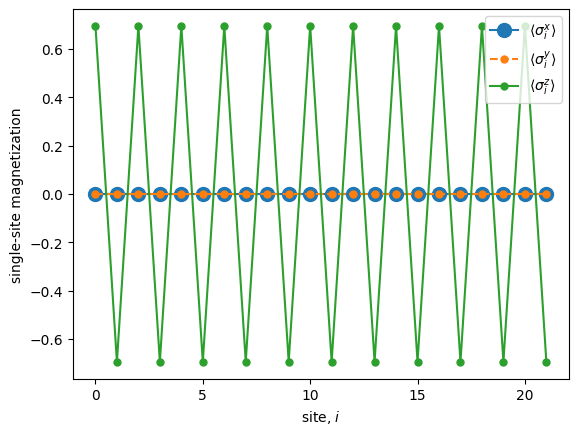

In [6]:
import matplotlib.pyplot as plt

plt.plot(s_x, marker=".", markersize=20, label="x")
plt.plot(s_y, marker=".", linestyle="--", markersize=10, label="y")
plt.plot(s_z, marker=".", markersize=10, label="z")

plt.legend(
    [r"$\langle\sigma^x_i\rangle$", r"$\langle\sigma^y_i\rangle$", r"$\langle\sigma^z_i\rangle$"]
)
plt.xlabel("site, $i$")
plt.ylabel("single-site magnetization")
plt.show()

Once we have computed the average magnetization on each site, we can compute the 
connected correlators as well.

In [7]:
max_distance = num_spins // 2

c_x = np.zeros(max_distance)
c_y = np.zeros(max_distance)
c_z = np.zeros(max_distance)
distance_counts = np.zeros(max_distance)

for i in range(num_spins):
    for j in range(i + 1, num_spins):
        j_wrap = j % num_spins  # Connect qubits N and 0
        distance = min([abs(i - j), abs(i + (num_spins - j))])

        # Sigma_x Sigma_x
        pstr = ["I" for _ in range(num_spins)]
        pstr[i] = "X"
        pstr[j_wrap] = "X"
        pauli_op = SparsePauliOp("".join(pstr))
        sparse_op = project_operator_to_subspace(bitstring_matrix, pauli_op)
        c_x[distance - 1] += (
            np.real(np.conjugate(min_eigenstate).T @ sparse_op @ min_eigenstate)
            - s_x[i] * s_x[j_wrap]
        )

        # Sigma_y Sigma_y
        pstr = ["I" for _ in range(num_spins)]
        pstr[i] = "Y"
        pstr[j_wrap] = "Y"
        pauli_op = SparsePauliOp("".join(pstr))
        sparse_op = project_operator_to_subspace(bitstring_matrix, pauli_op)
        c_y[distance - 1] += (
            np.real(np.conjugate(min_eigenstate).T @ sparse_op @ min_eigenstate)
            - s_y[i] * s_y[j_wrap]
        )

        # Sigma_z Sigma_z
        pstr = ["I" for _ in range(num_spins)]
        pstr[i] = "Z"
        pstr[j_wrap] = "Z"
        pauli_op = SparsePauliOp("".join(pstr))
        sparse_op = project_operator_to_subspace(bitstring_matrix, pauli_op)
        c_z[distance - 1] += (
            np.real(np.conjugate(min_eigenstate).T @ sparse_op @ min_eigenstate)
            - s_z[i] * s_z[j_wrap]
        )

        distance_counts[distance - 1] += 1
c_x /= distance_counts
c_y /= distance_counts
c_z /= distance_counts

We can see that the Z correlation shows true long range order (the correlator does not decay to 0). The X,Y correlators decay to 0 with distance between spin pairs.

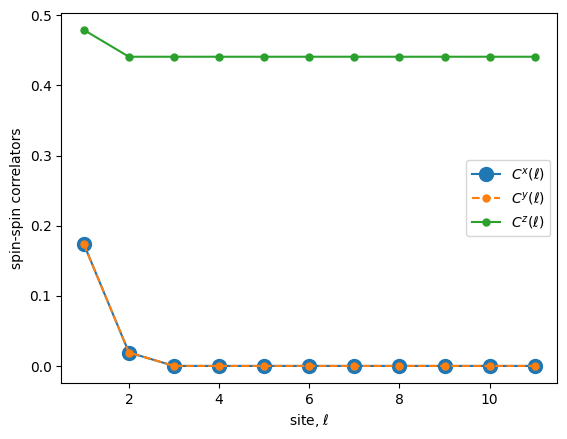

In [8]:
plt.plot(np.arange(1, max_distance + 1), np.abs(c_x), marker=".", markersize=20, label="xx")
plt.plot(
    np.arange(1, max_distance + 1),
    np.abs(c_y),
    marker=".",
    linestyle="--",
    markersize=10,
    label="yy",
)
plt.plot(np.arange(1, max_distance + 1), np.abs(c_z), marker=".", markersize=10, label="zz")

plt.legend([r"$C^x(\ell)$", r"$C^y(\ell)$", r"$C^z(\ell)$"])
plt.xlabel(r"site, $\ell$")
plt.ylabel("spin-spin correlators")
plt.show()